## Analyzing A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction
In this project, I will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, reading the dataset and looking into top few rows.

In [4]:
df = pd.read_csv('ab_data.csv')

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. To find the number of rows in the dataset, we use 'shape' function.

In [6]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [7]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [8]:
df.query('converted==1')['user_id'].nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [9]:
df.query("landing_page=='new_page' and group=='treatment'").shape[0]

145311

In [10]:
df.query("landing_page=='old_page' and group=='control'").shape[0]

145274

In [11]:
df.shape[0]-(df.query("landing_page=='new_page' and group=='treatment'").shape[0])-df.query("landing_page=='old_page' and group=='control'").shape[0]

3893

f. Do any of the rows have missing values?

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [13]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a.Storing our new dataframe in **df2**.

In [14]:
df_group_first = df.query("landing_page=='old_page'and group=='control'")

In [15]:
df_group_second = df.query("landing_page=='new_page'and group=='treatment'")

In [16]:
frames = [df_group_first, df_group_second]
df2=pd.concat(frames)

In [17]:
df2.shape

(290585, 5)

In [18]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using **df2** to find some answers.

a. How many unique **user_id**s are in **df2**?

In [19]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [20]:
df2.groupby('user_id')['user_id'].count().sort_values(ascending=False).head(1)

user_id
773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [21]:
df2.query("user_id==773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [22]:
df2.drop(df.index[1899],inplace=True)

In [23]:
df2.shape

(290584, 5)

In [24]:
df2.groupby('user_id')['user_id'].count().sort_values(ascending=False).head(1)

user_id
945999    1
Name: user_id, dtype: int64

`4.` 
a. Calculate the probability of an individual converting regardless of the page they receive?

In [28]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [29]:
df2.query("group=='control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [30]:
df2.query("group=='treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [31]:
df2.query("landing_page=='new_page'").shape[0]/df2.shape[0]

0.5000619442226688

e. Observations on whether we think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Observations**
- The old page leads to more conversions as we can see:
    - the probability that the controlled group(old_page) conversions are 12.04%, 
    - whereas the treatment group(new_page) conversions are 11.88%,
    - with a difference of approximately 0.16%.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  Our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


- Null hypothesis:
>**$p_{new}$**=<**$p_{old}$** 

>**$H_{0}$**: The conversion probability of the old page is better than or equal to the new page,  at a Type I error rate of 5%.


- Alternate hypothesis:
>**$p_{new}$**>**$p_{old}$**

>**$H_{1}$**: The new page conversion probability is better than the old page,  at a Type I error rate of 5%.


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Follow along with us in the cells below to identify the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - we are going to work through the problems below to complete this problem.  <br><br>

a. The **convert rate** for $p_{new}$ under the null? 

In [41]:
#As we assume under tha null that there is no difference between 2 groups. That is why we don't have to calculate the p in 2 groups.
p_new = df2.query("converted==1").user_id.nunique()/df2.user_id.nunique()
p_new

0.11959708724499628

b. The **convert rate** for $p_{old}$ under the null? <br><br>

In [42]:
#As we assume under tha null that there is no difference between 2 groups. That is why we don't have to calculate the p in 2 groups.
p_old = df2.query("converted==1").user_id.nunique()/df2.user_id.nunique()
p_old

0.11959708724499628

c. The $n_{new}$?

In [43]:
n_new = df2.query("landing_page=='new_page'").shape[0]
n_new

145310

d. The $n_{old}$?

In [44]:
n_old = df2.query("landing_page=='old_page'").shape[0]
n_old

145274

e. Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [45]:
new_page_converted = np.random.choice([0,1],size=n_new,p=[(1-p_new),p_new])

f. Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [46]:
old_page_converted = np.random.choice([0,1],size=n_old,p=[(1-p_old),p_old])

g. Finding $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [47]:
# compute the new p_new and p_old after simulation
p_new=new_page_converted.mean()
p_old=old_page_converted.mean()
p_new-p_old


0.0012437344553397067

h. Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one we calculated in parts **a. through g.** above.  Storing all 10,000 values in a numpy array called **p_diffs**.

In [48]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.choice([0,1],size=n_new,p=[(1-p_new),p_new])
    old_page_converted = np.random.choice([0,1],size=n_old,p=[(1-p_old),p_old])
    diff = new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(diff)
    
    
    


i. Ploting a histogram of the **p_diffs**.  Does this plot look like what we expected?  

In [49]:
p_diffs = np.array(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

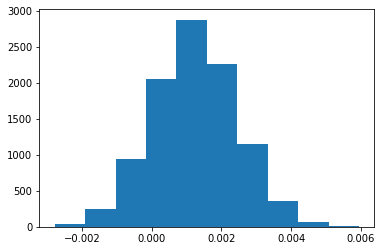

In [50]:
plt.hist(p_diffs);

In [51]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

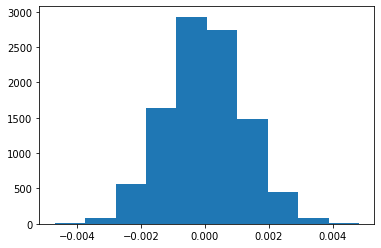

In [52]:
plt.hist(null_vals);

In [53]:
obs_diff = (df2.query("landing_page=='new_page'").converted.mean() - df2.query("landing_page=='old_page'").converted.mean())
obs_diff

-0.0015782389853555567

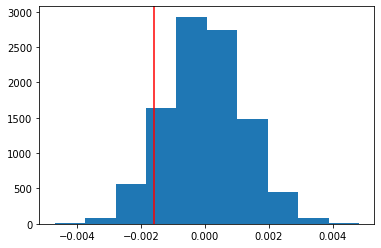

In [54]:
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red');


In [55]:
(p_diffs > obs_diff).mean()

0.9915

k. Explaining what we just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Explanation**


The value computed is the p-value, which is the probability of observing data in favor of the alternative given the null hypothesis is true. As p-value is greater than 0.05, we fail to reject null hypothesis. In simple words, the conversion probability of the old page is better than or equal to the new page one.



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [56]:
import statsmodels.api as sm

convert_old = df2.query("landing_page=='old_page'").converted.mean()
convert_new = df2.query("landing_page=='new_page'").converted.mean()
n_old = df2.query("landing_page=='old_page'").shape[0]
n_new = df2.query("landing_page=='new_page'").shape[0]

print(convert_old)
print(convert_new)
print(n_old)
print(n_new)



0.1203863045004612
0.11880806551510564
145274
145310


m. Now using `stats.proportions_ztest` to compute our test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [57]:
convert_old_ct = df2.query("group=='control'and converted==1")['user_id'].count()
print(convert_old_ct)



17489


In [58]:
convert_new_ct = df2.query("group=='treatment'and converted==1")['user_id'].count()
print(convert_new_ct)




17264


In [59]:
z_score, p_value = sm.stats.proportions_ztest([17489, 17264], [145274, 145310], alternative='smaller')
z_score, p_value

#http://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html



(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Explanation**

Z scores and p-values are associated with the standard normal distribution, as z scores are measures of standard deviation.As we can see here p-value matches the outcome in **j** and **k**, which means we fail to reject null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**Explanation**

As we want to predict a categorical result, so we will use logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [60]:
df2['intercept'] = 1
df2[['control','treatment']]=pd.get_dummies(df2['group'])

In [61]:
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0


In [62]:
df2.drop('control',axis=1,inplace=True)


In [63]:
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Using **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [64]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'], df2[['intercept','treatment']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        11:00:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Providing the summary of our model below.

**summary**

As we can see in this model, the coefficient of the intercept is -1.9888 with a p-value 0f 0, and the coefficient of the treatment is -0.0150 with a p-value of 0.190.

e. The p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>

**Explanation**

The p-value in part 3 is 0.190, which is small with respect to what we saw in part 2. More impotantly the value is larger than alpha value of 0.05, which does not show that the treatment(ab_page) is statistically significant in this model. 

The regression model which we want to know here is, if ab_page is associated with the change of conversion rate. That is why the null hypothesis here is, that the conversion rate of the old page is same as the new page, and tha alternate hypothesis is that the rate is different between the old and new page.

To conclude, the regression model here is a two-sided model, where as it was one side model in part 2.

f. Now, lets considering other things that might influence whether or not an individual converts.  Discussing why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Explanations**

I think it will be better to have other factors involved in regression mode, because:
- the independent variables which we did not consider in our current model may correlate with the current independent variable, which causes multicollinearity problem. So we can try adding more independent variables which can help us understand the relationship better.
- including independent variables might help us decrease the risk of bias.
- including independent variables might help us decrease the risk of Simpson's paradox, which means a trend shown in several different groups of data but disappearing at the same time if the data/group is combined.

Whereas on the contrary the regression model might overfit as well.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion?  

In [65]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [66]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [67]:
df_country.shape

(290584, 2)

In [68]:
df_new=df2.join(df_country.set_index('user_id'),on='user_id')


In [69]:
df_new.head()


,user_id,timestamp,group,landing_page,converted,intercept,treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [70]:
df_new.shape


(290584, 8)

In [71]:
df_new.groupby('country')['user_id'].count() 


country
CA     14499
UK     72466
US    203619
Name: user_id, dtype: int64

In [72]:
df_new[['CA','UK','US']]= pd.get_dummies(df_new['country']) 


In [73]:
df_new.head()


,user_id,timestamp,group,landing_page,converted,intercept,treatment,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1


In [74]:
df_new = df_new.drop('CA',axis=1) 


In [75]:
df_new.head()


,user_id,timestamp,group,landing_page,converted,intercept,treatment,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,1


In [76]:
logit_mod2 = sm.Logit(df_new['converted'],df_new[['intercept','treatment','UK','US']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 30 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        11:12:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Findings from above:

- It appears that country does not have an impact on conversion, as the p-values of UK and US are all greater than the alpha level(0.05), which states that they are not statistically significant.

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Providing the summary results, and your conclusions based on the results.

In [77]:
#By muliplying two independent variables, we can find there interations
df_new['page_US']=df_new['treatment']*df_new['US']


In [78]:
df_new['page_UK']=df_new['treatment']*df_new['UK']


In [79]:
df_new.head()


,user_id,timestamp,group,landing_page,converted,intercept,treatment,country,UK,US,page_US,page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,1,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,1,0,0


In [80]:
logit_mod3 = sm.Logit(df_new['converted'], df_new[['intercept','treatment','UK','US','page_UK','page_US']])
results3 = logit_mod3 .fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 30 Mar 2021   Pseudo R-squ.:               3.482e-05
Time:                        11:12:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
treatment     -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
page_UK        0.0783      0.057      1.378      0.168      -0.033       0.190
page_US        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

Findings from above:

- The cofficients of the treatment, UK, and US have changed but their p-values are still larger than the alpha(0.05), which means that they do not have an impact on the conversion rate.
- Looking at the interactions between page and country(page_UK, page_US), there is no significant effects on conversion since the p-values of those two variables(0.168, 0.383) are larger than alpha(0.05).